In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from scipy import stats
from scipy.stats import ks_2samp, gaussian_kde
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Configuration

In [2]:
# =============================================================================
# FEATURE ASSIGNMENT STRATEGY
# =============================================================================

FEATURE_ASSIGNMENT = {
    # SMOTE-KMeans: Features with good correlation preservation needed
    # These are "static" features that don't need complex temporal modeling
    'smote_kmeans': [
        'announcements',        # Base volume - SMOTE handles well
        'withdrawals',          # Base volume
        'nlri_ann',             # Correlated with announcements
        'dups',                 # Simple count
        'origin_0',             # Categorical-like
        'origin_2',             # Categorical-like
        'origin_changes',       # Low complexity
        'as_path_max',          # SMOTE preserves distribution
        'imp_wd_spath',         # Correlated feature
        'imp_wd_dpath',         # Correlated feature
    ],
    
    # Empirical Sampling: Heavy-tailed features - sample from KDE
    'empirical_kde': [
        'unique_as_path_max',   # Worst feature - use empirical
        'edit_distance_max',    # Heavy-tailed
        'edit_distance_avg',    # Continuous
        'rare_ases_avg',        # Heavy-tailed, Zipf-like
    ],
    
    # Conditional Generation: Derived from other features
    'conditional': [
        'edit_distance_dict_0', 
        'edit_distance_dict_1',
        'edit_distance_dict_2', 
        'edit_distance_dict_3',
        'edit_distance_dict_4',
        'edit_distance_dict_5',
        'edit_distance_dict_6',
        'edit_distance_unique_dict_0',
        'edit_distance_unique_dict_1',
    ],
    
    # Zero-Inflated Mixture: Sparse event-driven features
    'mixture_model': [
        'flaps',                # Sparse, event-driven
        'nadas',                # Sparse, event-driven  
        'imp_wd',               # Can be sparse
        'number_rare_ases',     # Integer count, sparse
    ]
}

# All 27 features (using underscore convention: origin_0, nlri_ann)
ALL_FEATURES = [
    'announcements', 'withdrawals', 'nlri_ann', 'dups',
    'origin_0', 'origin_2', 'origin_changes',
    'imp_wd', 'imp_wd_spath', 'imp_wd_dpath',
    'as_path_max', 'unique_as_path_max',
    'edit_distance_avg', 'edit_distance_max',
    'edit_distance_dict_0', 'edit_distance_dict_1', 'edit_distance_dict_2',
    'edit_distance_dict_3', 'edit_distance_dict_4', 'edit_distance_dict_5',
    'edit_distance_dict_6',
    'edit_distance_unique_dict_0', 'edit_distance_unique_dict_1',
    'number_rare_ases', 'rare_ases_avg',
    'nadas', 'flaps'
]

# Integer features (must be rounded) - CRITICAL: must be enforced AFTER all processing
INTEGER_FEATURES = [
    'announcements', 'withdrawals', 'nlri_ann', 'dups',
    'origin_0', 'origin_2', 'origin_changes',
    'imp_wd', 'imp_wd_spath', 'imp_wd_dpath',
    'as_path_max', 'unique_as_path_max',
    'edit_distance_max',
    'edit_distance_dict_0', 'edit_distance_dict_1', 'edit_distance_dict_2',
    'edit_distance_dict_3', 'edit_distance_dict_4', 'edit_distance_dict_5',
    'edit_distance_dict_6',
    'edit_distance_unique_dict_0', 'edit_distance_unique_dict_1',
    'number_rare_ases', 'nadas', 'flaps'
]

# =============================================================================
# FEATURE NAME MAPPING (for GAN compatibility)
# =============================================================================
# GAN notebooks may use different naming conventions (no underscores)
# This mapping allows seamless integration

FEATURE_NAME_MAPPING = {
    # GAN format (lowercase, no underscores) -> Standard format (with underscores)
    'nlriann': 'nlri_ann',
    'origin0': 'origin_0',
    'origin2': 'origin_2',
    'impwd': 'imp_wd',
    'impwdspath': 'imp_wd_spath',
    'impwddpath': 'imp_wd_dpath',
    'aspathmax': 'as_path_max',
    'uniqueaspathmax': 'unique_as_path_max',
    'editdistanceavg': 'edit_distance_avg',
    'editdistancemax': 'edit_distance_max',
    'editdistancedict0': 'edit_distance_dict_0',
    'editdistancedict1': 'edit_distance_dict_1',
    'editdistancedict2': 'edit_distance_dict_2',
    'editdistancedict3': 'edit_distance_dict_3',
    'editdistancedict4': 'edit_distance_dict_4',
    'editdistancedict5': 'edit_distance_dict_5',
    'editdistancedict6': 'edit_distance_dict_6',
    'editdistanceuniquedict0': 'edit_distance_unique_dict_0',
    'editdistanceuniquedict1': 'edit_distance_unique_dict_1',
    'numberrareases': 'number_rare_ases',
    'rareasesavg': 'rare_ases_avg',  # Fixed typo: was 'rareasesvg'
}

# Reverse mapping (Standard -> GAN format)
FEATURE_NAME_MAPPING_REVERSE = {v: k for k, v in FEATURE_NAME_MAPPING.items()}

def standardize_column_names(df):
    """Convert GAN-style column names to standard underscore format."""
    rename_dict = {}
    for col in df.columns:
        col_lower = col.lower().replace('_', '')
        if col_lower in FEATURE_NAME_MAPPING:
            rename_dict[col] = FEATURE_NAME_MAPPING[col_lower]
        elif col.lower() in FEATURE_NAME_MAPPING:
            rename_dict[col] = FEATURE_NAME_MAPPING[col.lower()]
    
    if rename_dict:
        print(f"Standardized {len(rename_dict)} column names: {list(rename_dict.keys())}")
        df = df.rename(columns=rename_dict)
    return df

# Generation settings
N_SYNTHETIC = 20000  # Number of samples to generate
N_CLUSTERS = 15      # For KMeans-SMOTE
RANDOM_STATE = 42

print("Configuration loaded!")
print(f"\nFeature assignment:")
for strategy, features in FEATURE_ASSIGNMENT.items():
    print(f"  {strategy}: {len(features)} features")
print(f"\nFeature name mapping defined for {len(FEATURE_NAME_MAPPING)} GAN-style names")

Configuration loaded!

Feature assignment:
  smote_kmeans: 10 features
  empirical_kde: 4 features
  conditional: 9 features
  mixture_model: 4 features

Feature name mapping defined for 21 GAN-style names


## 2. Load Real Data

In [3]:
# Load your real BGP data
# Adjust path as needed
DATA_PATH = '/home/smotaali/GAN_Traffic_Producer/RIPE/rrc04_updates_20251116_extracted_discovered.csv'  # or your data path

try:
    df_real = pd.read_csv(DATA_PATH)
    print(f"Loaded {len(df_real)} samples")
except FileNotFoundError:
    print(f"File not found at {DATA_PATH}")
    print("Please update DATA_PATH to point to your real BGP data")
    # Create dummy data for demonstration
    print("\nCreating dummy data for demonstration...")
    np.random.seed(42)
    df_real = pd.DataFrame({
        col: np.random.exponential(scale=10, size=10000) 
        for col in ALL_FEATURES
    })

# Filter to only the features we need
available_features = [f for f in ALL_FEATURES if f in df_real.columns]
X_real = df_real[available_features].copy()

print(f"\nUsing {len(available_features)} features")
print(f"Real data shape: {X_real.shape}")

Loaded 86387 samples

Using 27 features
Real data shape: (86387, 27)


## 3. Generator Functions

In [4]:
# =============================================================================
# SMOTE-KMeans Generator (for correlated features)
# =============================================================================

def generate_smote_kmeans(X, features, n_samples, n_clusters=15, random_state=42):
    """
    Generate samples using KMeans clustering + SMOTE.
    Best for features requiring correlation preservation.
    
    Parameters:
    -----------
    X : DataFrame - Real data
    features : list - Features to generate
    n_samples : int - Number of samples to generate
    n_clusters : int - Number of KMeans clusters
    
    Returns:
    --------
    DataFrame with generated features
    """
    np.random.seed(random_state)
    
    # Filter to available features
    available = [f for f in features if f in X.columns]
    if not available:
        return pd.DataFrame()
    
    X_subset = X[available].values
    
    # Apply log1p transform for stability
    X_log = np.log1p(np.clip(X_subset, 0, None))
    
    # Scale for clustering
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_log)
    
    # KMeans clustering
    n_clusters_actual = min(n_clusters, len(X_subset) // 10)
    kmeans = KMeans(n_clusters=n_clusters_actual, random_state=random_state, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    # Allocate samples per cluster proportionally
    cluster_sizes = np.bincount(cluster_labels)
    samples_per_cluster = (cluster_sizes / cluster_sizes.sum() * n_samples).astype(int)
    samples_per_cluster = np.maximum(samples_per_cluster, 1)
    
    synthetic_all = []
    
    for cluster_id in range(n_clusters_actual):
        cluster_mask = cluster_labels == cluster_id
        X_cluster = X_log[cluster_mask]
        
        if len(X_cluster) < 3:
            continue
        
        n_to_generate = samples_per_cluster[cluster_id]
        minority_size = max(2, int(len(X_cluster) * 0.1))
        safe_k = min(3, minority_size - 1)
        
        if safe_k < 1:
            continue
        
        # Create artificial minority class for SMOTE
        minority_idx = np.random.choice(len(X_cluster), minority_size, replace=False)
        y_cluster = np.zeros(len(X_cluster))
        y_cluster[minority_idx] = 1
        
        try:
            smote = SMOTE(
                sampling_strategy={1: n_to_generate + minority_size},
                k_neighbors=safe_k,
                random_state=random_state
            )
            X_res, y_res = smote.fit_resample(X_cluster, y_cluster)
            synthetic = X_res[y_res == 1][minority_size:]
            synthetic_all.append(synthetic)
        except Exception as e:
            continue
    
    if synthetic_all:
        result = np.vstack(synthetic_all)
        # Inverse log1p transform
        result = np.expm1(result)
        result = np.clip(result, 0, None)
        return pd.DataFrame(result[:n_samples], columns=available)
    else:
        return pd.DataFrame(columns=available)

print("SMOTE-KMeans generator defined!")

SMOTE-KMeans generator defined!


In [5]:
# =============================================================================
# Empirical KDE Generator (for heavy-tailed features)
# =============================================================================

def generate_empirical_kde(X, features, n_samples, bandwidth_factor=0.5, random_state=42):
    """
    Generate samples using Kernel Density Estimation on real data.
    Best for heavy-tailed features that GANs struggle with.
    
    Uses adaptive bandwidth based on feature variance.
    
    Edge cases handled:
    - Constant features (std=0): bootstrap sample from unique value
    - Very low variance: bootstrap sampling fallback
    - KDE failures: bootstrap sampling fallback
    """
    np.random.seed(random_state)
    
    available = [f for f in features if f in X.columns]
    if not available:
        return pd.DataFrame()
    
    result = {}
    fallback_features = []  # Track features using fallback
    
    for feature in available:
        real_values = X[feature].values
        real_values = real_values[~np.isnan(real_values)]
        
        # Edge case: too few values
        if len(real_values) < 10:
            result[feature] = np.zeros(n_samples)
            fallback_features.append((feature, 'too_few_values'))
            continue
        
        # Edge case: constant or near-constant feature (std ≈ 0)
        feature_std = np.std(real_values)
        if feature_std < 1e-10:
            # Bootstrap sample from the constant value(s)
            result[feature] = np.random.choice(real_values, n_samples, replace=True)
            fallback_features.append((feature, 'constant'))
            continue
        
        # Edge case: very low variance relative to mean (coefficient of variation)
        cv = feature_std / (np.abs(np.mean(real_values)) + 1e-10)
        if cv < 0.01:  # Very low relative variance
            result[feature] = np.random.choice(real_values, n_samples, replace=True)
            fallback_features.append((feature, 'low_variance'))
            continue
        
        # Log transform for heavy-tailed distributions
        log_values = np.log1p(np.clip(real_values, 0, None))
        
        # Check if log-transformed values have sufficient variance
        if np.std(log_values) < 1e-10:
            result[feature] = np.random.choice(real_values, n_samples, replace=True)
            fallback_features.append((feature, 'low_log_variance'))
            continue
        
        try:
            # Fit KDE with Scott's rule bandwidth * factor
            kde = gaussian_kde(log_values, bw_method='scott')
            kde.set_bandwidth(kde.factor * bandwidth_factor)
            
            # Sample from KDE
            synthetic_log = kde.resample(n_samples).flatten()
            
            # Inverse transform
            synthetic = np.expm1(synthetic_log)
            synthetic = np.clip(synthetic, 0, np.percentile(real_values, 99.9))
            
            result[feature] = synthetic
            
        except Exception as e:
            # Fallback to bootstrap sampling
            result[feature] = np.random.choice(real_values, n_samples, replace=True)
            fallback_features.append((feature, f'kde_error: {str(e)[:30]}'))
    
    # Report fallback usage
    if fallback_features:
        print(f"  KDE fallback to bootstrap for {len(fallback_features)} features:")
        for feat, reason in fallback_features:
            print(f"    - {feat}: {reason}")
    
    return pd.DataFrame(result)

print("Empirical KDE generator defined (with edge case handling)!")

Empirical KDE generator defined (with edge case handling)!


In [6]:
# =============================================================================
# Zero-Inflated Mixture Generator (for sparse features)
# =============================================================================

def generate_mixture_model(X, features, n_samples, random_state=42):
    """
    Generate sparse features using zero-inflated mixture model.
    
    Model: P(x) = p_zero * I(x=0) + (1-p_zero) * f(x|x>0)
    
    Best for features like 'flaps', 'nadas' that are often zero.
    """
    np.random.seed(random_state)
    
    available = [f for f in features if f in X.columns]
    if not available:
        return pd.DataFrame()
    
    result = {}
    
    for feature in available:
        real_values = X[feature].values
        real_values = real_values[~np.isnan(real_values)]
        
        # Calculate zero probability
        p_zero = (real_values == 0).mean()
        
        # Get non-zero values
        non_zero = real_values[real_values > 0]
        
        synthetic = np.zeros(n_samples)
        
        # Determine which samples are non-zero
        non_zero_mask = np.random.random(n_samples) > p_zero
        n_non_zero = non_zero_mask.sum()
        
        if n_non_zero > 0 and len(non_zero) > 0:
            # Sample from non-zero distribution with small noise
            sampled = np.random.choice(non_zero, n_non_zero, replace=True)
            # Add small perturbation
            noise = np.random.normal(0, non_zero.std() * 0.1, n_non_zero)
            synthetic[non_zero_mask] = np.maximum(1, sampled + noise)
        
        result[feature] = synthetic
    
    return pd.DataFrame(result)

print("Mixture model generator defined!")

Mixture model generator defined!


In [7]:
# =============================================================================
# Conditional Generator (for edit_distance_dict features)
# =============================================================================

def generate_conditional(X, features, n_samples, synthetic_base, random_state=42):
    """
    Generate edit_distance_dict features conditioned on:
    - announcements (volume)
    - edit_distance_max (upper bound)
    
    The dict values should follow a distribution where:
    - Lower edit distances (0-2) are more common
    - Higher edit distances (3-6) are rare
    - Sum relates to announcement volume
    """
    np.random.seed(random_state)
    
    available = [f for f in features if f in X.columns]
    if not available:
        return pd.DataFrame()
    
    # Learn the conditional distribution from real data
    # P(edit_distance_dict_i | announcements, edit_distance_max)
    
    result = {}
    
    # Get conditioning variables from synthetic_base if available
    if 'announcements' in synthetic_base.columns:
        syn_announcements = synthetic_base['announcements'].values
    else:
        syn_announcements = np.random.choice(X['announcements'].values, n_samples)
    
    if 'edit_distance_max' in synthetic_base.columns:
        syn_ed_max = synthetic_base['edit_distance_max'].values.astype(int)
    else:
        syn_ed_max = np.random.choice(X['edit_distance_max'].values, n_samples).astype(int)
    
    # Learn typical distribution shape from real data
    ed_dict_cols = [f'edit_distance_dict_{i}' for i in range(7) if f'edit_distance_dict_{i}' in X.columns]
    
    if ed_dict_cols:
        # Calculate average proportions
        real_ed_dict = X[ed_dict_cols].values
        row_sums = real_ed_dict.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1  # Avoid division by zero
        proportions = (real_ed_dict / row_sums).mean(axis=0)
        
        # Generate for each sample
        for i, col in enumerate(ed_dict_cols):
            # Scale by announcements (more announcements = more edit events)
            scale_factor = np.log1p(syn_announcements) / np.log1p(X['announcements'].mean())
            base_value = X[col].mean() * scale_factor
            
            # Add noise
            noise = np.random.normal(0, X[col].std() * 0.3, n_samples)
            synthetic_col = np.maximum(0, base_value + noise)
            
            # Zero out values beyond edit_distance_max
            if i > 0:  # dict_1 and above
                synthetic_col[syn_ed_max < i] = 0
            
            result[col] = synthetic_col
    
    # Handle edit_distance_unique_dict features similarly
    ed_unique_cols = [f'edit_distance_unique_dict_{i}' for i in range(2) 
                     if f'edit_distance_unique_dict_{i}' in X.columns]
    
    for col in ed_unique_cols:
        real_values = X[col].values
        scale_factor = np.log1p(syn_announcements) / np.log1p(X['announcements'].mean())
        base_value = real_values.mean() * scale_factor
        noise = np.random.normal(0, real_values.std() * 0.3, n_samples)
        result[col] = np.maximum(0, base_value + noise)
    
    return pd.DataFrame(result)

print("Conditional generator defined!")

Conditional generator defined!


## 4. Correlation Alignment

In [8]:
# =============================================================================
# Correlation Alignment via Cholesky Decomposition
# =============================================================================

def align_correlations(synthetic, real, features_to_align=None):
    """
    Adjust synthetic data to match real correlation structure.
    
    Uses Cholesky decomposition to impose correlation structure:
    1. Decorrelate synthetic data
    2. Re-correlate with real data's correlation matrix
    
    Parameters:
    -----------
    synthetic : DataFrame - Generated data
    real : DataFrame - Real data
    features_to_align : list - Features to align (default: all common)
    
    Returns:
    --------
    DataFrame with aligned correlations
    """
    if features_to_align is None:
        features_to_align = [c for c in synthetic.columns if c in real.columns]
    
    if len(features_to_align) < 2:
        return synthetic
    
    try:
        # Get correlation matrices
        real_subset = real[features_to_align].dropna()
        syn_subset = synthetic[features_to_align].copy()
        
        # Handle NaN in synthetic data before correlation
        for col in syn_subset.columns:
            if syn_subset[col].isna().any():
                syn_subset[col] = syn_subset[col].fillna(syn_subset[col].median())
        
        # Check if we have enough valid data
        if len(real_subset) < 10 or len(syn_subset) < 10:
            print(f"  Warning: Not enough data for correlation alignment")
            return synthetic
        
        real_corr = real_subset.corr().values
        syn_corr = syn_subset.corr().values
        
        # Check for NaN in correlation matrices
        if np.isnan(real_corr).any() or np.isnan(syn_corr).any():
            print(f"  Warning: NaN in correlation matrix, skipping alignment")
            return synthetic
        
        # Add small regularization for numerical stability
        eps = 1e-6
        real_corr = real_corr + eps * np.eye(len(features_to_align))
        syn_corr = syn_corr + eps * np.eye(len(features_to_align))
        
        # Ensure matrices are positive definite
        try:
            L_real = np.linalg.cholesky(real_corr)
            L_syn = np.linalg.cholesky(syn_corr)
        except np.linalg.LinAlgError:
            # Matrix not positive definite, try to fix it
            # Use eigenvalue decomposition to make it positive definite
            eigvals_real, eigvecs_real = np.linalg.eigh(real_corr)
            eigvals_syn, eigvecs_syn = np.linalg.eigh(syn_corr)
            
            eigvals_real = np.maximum(eigvals_real, eps)
            eigvals_syn = np.maximum(eigvals_syn, eps)
            
            real_corr = eigvecs_real @ np.diag(eigvals_real) @ eigvecs_real.T
            syn_corr = eigvecs_syn @ np.diag(eigvals_syn) @ eigvecs_syn.T
            
            L_real = np.linalg.cholesky(real_corr)
            L_syn = np.linalg.cholesky(syn_corr)
        
        # Standardize synthetic data
        syn_mean = syn_subset.mean().values
        syn_std = syn_subset.std().values
        syn_std[syn_std == 0] = 1  # Avoid division by zero
        syn_std[np.isnan(syn_std)] = 1  # Handle NaN std
        
        syn_standardized = (syn_subset.values - syn_mean) / syn_std
        
        # Handle any NaN/Inf in standardized data
        syn_standardized = np.nan_to_num(syn_standardized, nan=0.0, posinf=0.0, neginf=0.0)
        
        # Decorrelate then re-correlate
        syn_decorr = syn_standardized @ np.linalg.inv(L_syn.T)
        syn_recorr = syn_decorr @ L_real.T
        
        # Rescale to match real data's scale
        real_mean = real_subset.mean().values
        real_std = real_subset.std().values
        real_std[real_std == 0] = 1  # Avoid division by zero
        real_std[np.isnan(real_std)] = 1  # Handle NaN std
        
        aligned = syn_recorr * real_std + real_mean
        
        # Handle any NaN/Inf in result
        aligned = np.nan_to_num(aligned, nan=0.0, posinf=0.0, neginf=0.0)
        
        # Update synthetic DataFrame
        result = synthetic.copy()
        for i, col in enumerate(features_to_align):
            result[col] = aligned[:, i]
        
        return result
        
    except Exception as e:
        print(f"  Correlation alignment failed: {e}")
        return synthetic

print("Correlation alignment function defined (with NaN/Inf handling)!")

Correlation alignment function defined (with NaN/Inf handling)!


## 5. Post-Processing & Constraints

In [9]:
# =============================================================================
# Post-Processing: Enforce BGP Domain Constraints
# =============================================================================

def enforce_bgp_constraints(synthetic, real, verbose=True):
    """
    Apply BGP domain-specific constraints to synthetic data.
    
    IMPORTANT: This function should be called as the FINAL step after all
    generation and correlation alignment, as it ensures:
    1. All features are non-negative
    2. All INTEGER_FEATURES are properly rounded to integers
    3. Domain constraints are satisfied
    
    Constraints:
    1. Handle NaN/Inf values first (fill with 0 or median)
    2. All features non-negative (clipped to 0)
    3. Integer features rounded to nearest integer
    4. origin_0 + origin_2 <= announcements
    5. edit_distance_dict_i = 0 when i > edit_distance_max
    6. Values within realistic bounds (99.5th percentile)
    7. FINAL: Re-clip and re-round all integer features
    """
    result = synthetic.copy()
    
    # Track constraint violations for reporting
    violations = {
        'nan_inf_values': 0,
        'negative_values': 0,
        'origin_constraint': 0,
        'edit_distance_constraint': 0,
        'bound_violations': 0
    }
    
    # 0. FIRST: Handle NaN and Inf values
    for col in result.columns:
        nan_count = result[col].isna().sum()
        inf_count = np.isinf(result[col].replace([np.inf, -np.inf], np.nan).dropna()).sum() if result[col].dtype in ['float64', 'float32'] else 0
        
        if nan_count > 0 or inf_count > 0:
            violations['nan_inf_values'] += nan_count + inf_count
            
            # Replace inf with NaN first
            result[col] = result[col].replace([np.inf, -np.inf], np.nan)
            
            # Fill NaN with 0 for integer features, median for others
            if col in INTEGER_FEATURES:
                result[col] = result[col].fillna(0)
            else:
                # Use median from real data if available
                if col in real.columns:
                    fill_value = real[col].median()
                else:
                    fill_value = 0
                result[col] = result[col].fillna(fill_value)
    
    # 1. Non-negative: Clip ALL features to >= 0
    for col in result.columns:
        neg_count = (result[col] < 0).sum()
        if neg_count > 0:
            violations['negative_values'] += neg_count
            result[col] = np.maximum(0, result[col])
    
    # 2. Integer features: First pass rounding
    for col in INTEGER_FEATURES:
        if col in result.columns:
            # Ensure no NaN before converting
            result[col] = result[col].fillna(0)
            result[col] = np.round(result[col]).astype(int)
    
    # 3. Origin constraint: origin_0 + origin_2 <= announcements
    origin_cols = ['origin_0', 'origin_2', 'announcements']
    if all(c in result.columns for c in origin_cols):
        origin_sum = result['origin_0'] + result['origin_2']
        excess_mask = origin_sum > result['announcements']
        violations['origin_constraint'] = excess_mask.sum()
        
        if excess_mask.any():
            # Scale down origin values to fit within announcements
            scale = result.loc[excess_mask, 'announcements'] / (origin_sum[excess_mask] + 1e-10)
            result.loc[excess_mask, 'origin_0'] = np.floor(result.loc[excess_mask, 'origin_0'] * scale).astype(int)
            result.loc[excess_mask, 'origin_2'] = np.floor(result.loc[excess_mask, 'origin_2'] * scale).astype(int)
    
    # 4. Edit distance max constraint: dict_i = 0 when i > edit_distance_max
    ed_dict_cols = [f'edit_distance_dict_{i}' for i in range(7) if f'edit_distance_dict_{i}' in result.columns]
    if 'edit_distance_max' in result.columns and ed_dict_cols:
        for idx in result.index:
            ed_max = int(result.loc[idx, 'edit_distance_max'])
            for i, col in enumerate(ed_dict_cols):
                if i > ed_max and result.loc[idx, col] != 0:
                    violations['edit_distance_constraint'] += 1
                    result.loc[idx, col] = 0
    
    # 5. Realistic bounds: Clip to 99.5th percentile of real data
    for col in result.columns:
        if col in real.columns:
            upper_bound = np.percentile(real[col].dropna(), 99.5)
            bound_violations = (result[col] > upper_bound * 1.1).sum()
            if bound_violations > 0:
                violations['bound_violations'] += bound_violations
                result[col] = np.clip(result[col], 0, upper_bound * 1.1)
    
    # 6. FINAL STEP: Re-ensure all integer features are properly typed
    # This is critical after all other operations that might introduce floats
    for col in INTEGER_FEATURES:
        if col in result.columns:
            # Ensure no NaN/Inf
            result[col] = result[col].fillna(0)
            result[col] = result[col].replace([np.inf, -np.inf], 0)
            # Clip to non-negative first
            result[col] = np.maximum(0, result[col])
            # Round to nearest integer
            result[col] = np.round(result[col]).astype(int)
    
    # Report violations if verbose
    if verbose:
        total_violations = sum(violations.values())
        if total_violations > 0:
            print(f"  Constraint violations fixed:")
            for constraint, count in violations.items():
                if count > 0:
                    print(f"    - {constraint}: {count}")
        else:
            print("  No constraint violations detected")
    
    return result

# Standalone function for final integer enforcement (can be called separately)
def final_integer_enforcement(df):
    """
    Ensure all INTEGER_FEATURES are non-negative integers.
    Call this as the absolute final step before saving/returning data.
    Handles NaN and Inf values safely.
    """
    result = df.copy()
    for col in INTEGER_FEATURES:
        if col in result.columns:
            # Handle NaN/Inf first
            result[col] = result[col].fillna(0)
            result[col] = result[col].replace([np.inf, -np.inf], 0)
            # Clip and round
            result[col] = np.maximum(0, result[col])
            result[col] = np.round(result[col]).astype(int)
    return result

print("BGP constraints function defined (with NaN/Inf handling)!")

BGP constraints function defined (with NaN/Inf handling)!


## 6. Main Hybrid Generation Pipeline

In [10]:
# =============================================================================
# HYBRID GENERATION PIPELINE
# =============================================================================

def generate_hybrid(X_real, n_samples, feature_assignment, random_state=42):
    """
    Main hybrid generation pipeline combining multiple strategies.
    
    Pipeline:
    1. SMOTE-KMeans for correlated features
    2. Empirical KDE for heavy-tailed features
    3. Mixture model for sparse features
    4. Conditional generation for dependent features
    5. Correlation alignment
    6. BGP constraint enforcement
    """
    print("="*70)
    print("HYBRID SMOTE-GAN GENERATION PIPELINE")
    print("="*70)
    
    synthetic_parts = {}
    
    # Step 1: SMOTE-KMeans for base features
    print("\n[1/6] Generating SMOTE-KMeans features...")
    smote_features = feature_assignment.get('smote_kmeans', [])
    if smote_features:
        synthetic_parts['smote'] = generate_smote_kmeans(
            X_real, smote_features, n_samples, 
            n_clusters=N_CLUSTERS, random_state=random_state
        )
        print(f"    Generated {len(synthetic_parts['smote'].columns)} features via SMOTE-KMeans")
    
    # Step 2: Empirical KDE for heavy-tailed features
    print("\n[2/6] Generating Empirical KDE features...")
    kde_features = feature_assignment.get('empirical_kde', [])
    if kde_features:
        synthetic_parts['kde'] = generate_empirical_kde(
            X_real, kde_features, n_samples, random_state=random_state
        )
        print(f"    Generated {len(synthetic_parts['kde'].columns)} features via KDE")
    
    # Step 3: Mixture model for sparse features
    print("\n[3/6] Generating Mixture Model features...")
    mixture_features = feature_assignment.get('mixture_model', [])
    if mixture_features:
        synthetic_parts['mixture'] = generate_mixture_model(
            X_real, mixture_features, n_samples, random_state=random_state
        )
        print(f"    Generated {len(synthetic_parts['mixture'].columns)} features via Mixture")
    
    # Combine parts so far for conditioning
    synthetic_base = pd.concat(synthetic_parts.values(), axis=1)
    
    # Step 4: Conditional generation
    print("\n[4/6] Generating Conditional features...")
    conditional_features = feature_assignment.get('conditional', [])
    if conditional_features:
        synthetic_parts['conditional'] = generate_conditional(
            X_real, conditional_features, n_samples, 
            synthetic_base, random_state=random_state
        )
        print(f"    Generated {len(synthetic_parts['conditional'].columns)} features conditionally")
    
    # Combine all parts
    print("\n[5/6] Combining and aligning correlations...")
    synthetic_combined = pd.concat(synthetic_parts.values(), axis=1)
    
    # Ensure we have all expected columns
    for col in X_real.columns:
        if col not in synthetic_combined.columns:
            # Fallback: bootstrap sample from real data
            synthetic_combined[col] = np.random.choice(
                X_real[col].values, n_samples, replace=True
            )
    
    # Reorder columns to match real data
    synthetic_combined = synthetic_combined[[c for c in X_real.columns if c in synthetic_combined.columns]]
    
    # Correlation alignment
    # Focus on the most important correlated feature groups
    corr_groups = [
        ['announcements', 'withdrawals', 'nlri_ann', 'origin_0', 'origin_2'],
        ['as_path_max', 'unique_as_path_max', 'edit_distance_max', 'edit_distance_avg'],
        ['imp_wd', 'imp_wd_spath', 'imp_wd_dpath'],
    ]
    
    for group in corr_groups:
        available_group = [c for c in group if c in synthetic_combined.columns and c in X_real.columns]
        if len(available_group) >= 2:
            synthetic_combined = align_correlations(synthetic_combined, X_real, available_group)
    
    print(f"    Aligned correlations for {sum(len(g) for g in corr_groups)} features")
    
    # Step 6: Enforce BGP constraints
    print("\n[6/6] Enforcing BGP domain constraints...")
    synthetic_final = enforce_bgp_constraints(synthetic_combined, X_real)
    print(f"    Constraints enforced on {len(synthetic_final.columns)} features")
    
    print("\n" + "="*70)
    print(f"GENERATION COMPLETE: {len(synthetic_final)} samples, {len(synthetic_final.columns)} features")
    print("="*70)
    
    return synthetic_final

print("Hybrid generation pipeline defined!")

Hybrid generation pipeline defined!


## 7. Run Generation

In [11]:
# Generate synthetic data using hybrid approach
synthetic_hybrid = generate_hybrid(
    X_real, 
    N_SYNTHETIC, 
    FEATURE_ASSIGNMENT,
    random_state=RANDOM_STATE
)

print(f"\nGenerated shape: {synthetic_hybrid.shape}")
print(f"\nFirst few rows:")
synthetic_hybrid.head()

HYBRID SMOTE-GAN GENERATION PIPELINE

[1/6] Generating SMOTE-KMeans features...
    Generated 10 features via SMOTE-KMeans

[2/6] Generating Empirical KDE features...
    Generated 4 features via KDE

[3/6] Generating Mixture Model features...
    Generated 4 features via Mixture

[4/6] Generating Conditional features...
    Generated 9 features conditionally

[5/6] Combining and aligning correlations...
    Aligned correlations for 12 features

[6/6] Enforcing BGP domain constraints...
  Constraint violations fixed:
    - nan_inf_values: 71
    - negative_values: 33057
    - origin_constraint: 6223
    - edit_distance_constraint: 5056
    - bound_violations: 1258
    Constraints enforced on 27 features

GENERATION COMPLETE: 20000 samples, 27 features

Generated shape: (20000, 27)

First few rows:


,announcements,withdrawals,nlri_ann,dups,origin_0,origin_2,origin_changes,imp_wd,imp_wd_spath,imp_wd_dpath,...,edit_distance_dict_3,edit_distance_dict_4,edit_distance_dict_5,edit_distance_dict_6,edit_distance_unique_dict_0,edit_distance_unique_dict_1,number_rare_ases,rare_ases_avg,nadas,flaps
0,90,3,90,0,88,2,0,13,1,12,...,5,0,0,0,3,14,15,0.349776,12,0
1,219,0,219,2,218,1,0,32,11,21,...,0,0,0,0,0,0,4,0.129615,11,33
2,126,4,126,1,106,20,1,0,0,3,...,7,2,0,0,7,15,122,0.155759,38,1
3,43,2,43,0,32,10,0,5,0,7,...,0,1,0,0,0,10,25,0.163415,3,2
4,82,11,82,0,70,11,2,3,0,6,...,3,4,0,0,11,0,86,0.119092,0,0


## 8. Evaluation

In [12]:
# =============================================================================
# EVALUATION FUNCTIONS (Optimized)
# =============================================================================

def evaluate_quality(real, synthetic, feature_importance=None, precomputed_real_corr=None):
    """
    Comprehensive quality evaluation.
    
    Optimizations:
    - Precompute real correlation matrix outside per-feature loop
    - Accept precomputed_real_corr to avoid recomputation across multiple calls
    
    Returns dict with:
    - Per-feature KS statistics
    - Cohen's d effect sizes
    - Correlation matrix similarity
    - Overall weighted score
    """
    common_cols = [c for c in real.columns if c in synthetic.columns]
    
    if not common_cols:
        print("WARNING: No common columns between real and synthetic data!")
        print(f"  Real columns: {list(real.columns)[:5]}...")
        print(f"  Synthetic columns: {list(synthetic.columns)[:5]}...")
        return {'overall_score': 0, 'ks_stats': {}, 'cohens_d': {}, 'wasserstein': {}}
    
    results = {
        'ks_stats': {},
        'cohens_d': {},
        'wasserstein': {},
        'generation_method': {}  # Track which method generated each feature
    }
    
    # Per-feature evaluation
    for col in common_cols:
        real_vals = real[col].dropna().values
        syn_vals = synthetic[col].dropna().values
        
        if len(real_vals) == 0 or len(syn_vals) == 0:
            results['ks_stats'][col] = 1.0
            results['cohens_d'][col] = float('inf')
            results['wasserstein'][col] = 1.0
            continue
        
        # KS statistic
        ks_stat, _ = ks_2samp(real_vals, syn_vals)
        results['ks_stats'][col] = ks_stat
        
        # Cohen's d
        pooled_std = np.sqrt((real_vals.std()**2 + syn_vals.std()**2) / 2)
        if pooled_std > 0:
            cohens_d = (real_vals.mean() - syn_vals.mean()) / pooled_std
        else:
            cohens_d = 0
        results['cohens_d'][col] = cohens_d
        
        # Wasserstein distance (normalized)
        real_range = real_vals.max() - real_vals.min()
        syn_range = syn_vals.max() - syn_vals.min()
        
        if real_range > 0:
            real_norm = (real_vals - real_vals.min()) / (real_range + 1e-10)
        else:
            real_norm = np.zeros_like(real_vals)
            
        if syn_range > 0:
            syn_norm = (syn_vals - syn_vals.min()) / (syn_range + 1e-10)
        else:
            syn_norm = np.zeros_like(syn_vals)
            
        wasserstein = stats.wasserstein_distance(real_norm, syn_norm)
        results['wasserstein'][col] = wasserstein
    
    # Correlation similarity (OPTIMIZED: compute once)
    if precomputed_real_corr is not None:
        real_corr = precomputed_real_corr
    else:
        real_corr = real[common_cols].corr()
    
    syn_corr = synthetic[common_cols].corr()
    
    # Handle NaN correlations
    real_corr_flat = real_corr.values.flatten()
    syn_corr_flat = syn_corr.values.flatten()
    
    # Remove NaN pairs
    valid_mask = ~(np.isnan(real_corr_flat) | np.isnan(syn_corr_flat))
    if valid_mask.sum() > 1:
        corr_similarity = np.corrcoef(
            real_corr_flat[valid_mask], 
            syn_corr_flat[valid_mask]
        )[0, 1]
    else:
        corr_similarity = 0
    
    results['correlation_similarity'] = corr_similarity
    results['real_correlation_matrix'] = real_corr  # Cache for reuse
    
    # Summary statistics
    ks_values = list(results['ks_stats'].values())
    cohens_values = [abs(v) for v in results['cohens_d'].values() if np.isfinite(v)]
    wass_values = list(results['wasserstein'].values())
    
    results['mean_ks'] = np.mean(ks_values) if ks_values else 1.0
    results['mean_cohens_d'] = np.mean(cohens_values) if cohens_values else float('inf')
    results['mean_wasserstein'] = np.mean(wass_values) if wass_values else 1.0
    
    # Calculate scores (0-100 scale)
    ks_score = max(0, 100 * (1 - results['mean_ks'] * 2))
    effect_score = max(0, 100 * (1 - results['mean_cohens_d'] / 2))
    corr_score = max(0, results['correlation_similarity'] * 100) if np.isfinite(results['correlation_similarity']) else 0
    wass_score = max(0, 100 * (1 - results['mean_wasserstein'] * 2))
    
    results['component_scores'] = {
        'distribution_ks': ks_score,
        'effect_size': effect_score,
        'correlation': corr_score,
        'wasserstein': wass_score
    }
    
    weights = {'distribution_ks': 0.25, 'effect_size': 0.25, 'correlation': 0.25, 'wasserstein': 0.25}
    results['overall_score'] = sum(
        results['component_scores'][k] * weights[k] 
        for k in weights
    )
    
    # Report bootstrap/fallback features
    results['n_common_features'] = len(common_cols)
    results['n_total_real_features'] = len(real.columns)
    results['n_total_synthetic_features'] = len(synthetic.columns)
    
    return results

print("Evaluation functions defined (optimized with correlation caching)!")

# Run evaluation
eval_results = evaluate_quality(X_real, synthetic_hybrid)

print("="*70)
print("HYBRID APPROACH EVALUATION RESULTS")
print("="*70)

print(f"\nOVERALL SCORE: {eval_results['overall_score']:.1f}/100")

print(f"\nComponent Scores:")
for component, score in eval_results['component_scores'].items():
    print(f"  {component}: {score:.1f}")

print(f"\nSummary Statistics:")
print(f"  Mean KS Statistic: {eval_results['mean_ks']:.4f}")
print(f"  Mean |Cohen's d|: {eval_results['mean_cohens_d']:.4f}")
print(f"  Correlation Similarity: {eval_results['correlation_similarity']:.4f}")
print(f"  Mean Wasserstein: {eval_results['mean_wasserstein']:.4f}")

Evaluation functions defined (optimized with correlation caching)!
HYBRID APPROACH EVALUATION RESULTS

OVERALL SCORE: 76.5/100

Component Scores:
  distribution_ks: 69.1
  effect_size: 97.7
  correlation: 59.0
  wasserstein: 80.4

Summary Statistics:
  Mean KS Statistic: 0.1546
  Mean |Cohen's d|: 0.0457
  Correlation Similarity: 0.5897
  Mean Wasserstein: 0.0982


In [13]:
# Worst features analysis
print("\n" + "="*70)
print("TOP-10 WORST FEATURES (by KS statistic)")
print("="*70)

ks_sorted = sorted(eval_results['ks_stats'].items(), key=lambda x: x[1], reverse=True)

for i, (feature, ks) in enumerate(ks_sorted[:10], 1):
    cohens_d = eval_results['cohens_d'][feature]
    wass = eval_results['wasserstein'][feature]
    print(f"{i:2}. {feature:30} KS={ks:.4f}  d={cohens_d:+.3f}  W={wass:.4f}")


TOP-10 WORST FEATURES (by KS statistic)
 1. imp_wd_dpath                   KS=0.4319  d=-0.091  W=0.0639
 2. edit_distance_dict_0           KS=0.3799  d=-0.005  W=0.1538
 3. edit_distance_unique_dict_0    KS=0.3650  d=+0.003  W=0.1700
 4. edit_distance_unique_dict_1    KS=0.2797  d=+0.009  W=0.1966
 5. edit_distance_dict_2           KS=0.2555  d=+0.113  W=0.1455
 6. origin_0                       KS=0.2538  d=+0.005  W=0.0875
 7. edit_distance_dict_3           KS=0.2181  d=+0.110  W=0.0911
 8. edit_distance_dict_1           KS=0.2089  d=+0.071  W=0.1518
 9. imp_wd                         KS=0.2068  d=+0.013  W=0.0313
10. announcements                  KS=0.1834  d=+0.006  W=0.0856


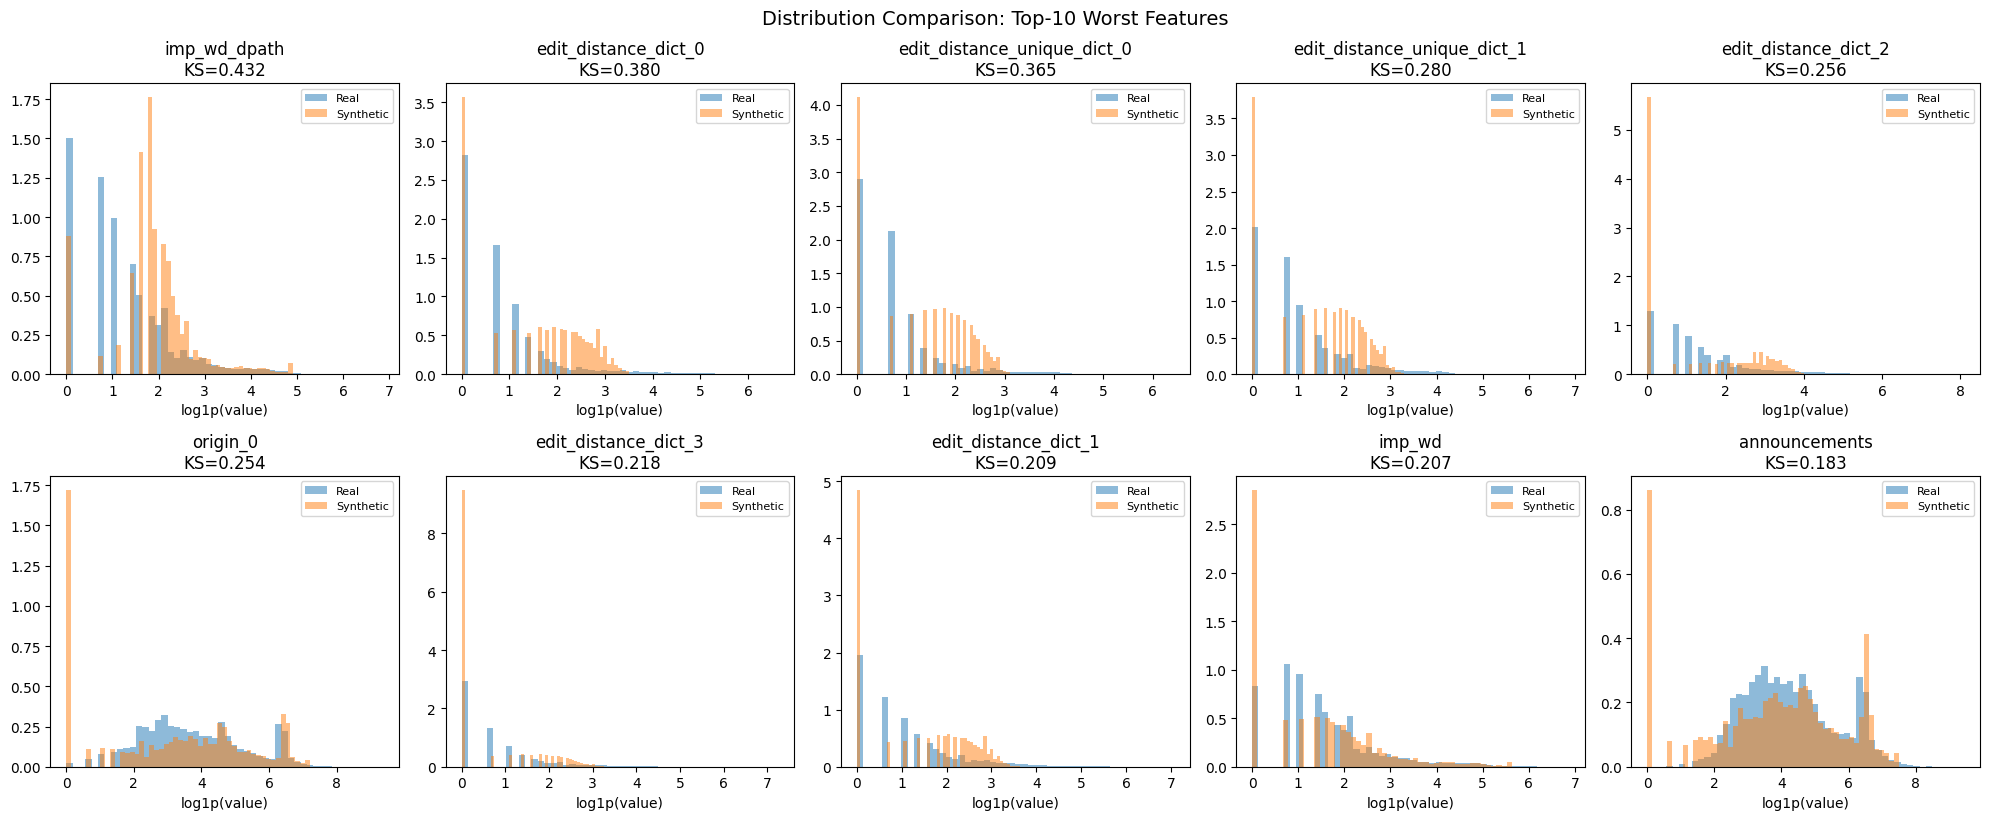

In [14]:
# Visualization: Distribution comparison for worst features
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

worst_10 = [f for f, _ in ks_sorted[:10]]

for idx, feature in enumerate(worst_10):
    ax = axes[idx]
    
    real_vals = X_real[feature].values
    syn_vals = synthetic_hybrid[feature].values
    
    # Use log scale for heavy-tailed
    if real_vals.max() > 100:
        real_vals = np.log1p(real_vals)
        syn_vals = np.log1p(syn_vals)
        ax.set_xlabel('log1p(value)')
    
    ax.hist(real_vals, bins=50, alpha=0.5, label='Real', density=True)
    ax.hist(syn_vals, bins=50, alpha=0.5, label='Synthetic', density=True)
    ax.set_title(f'{feature}\nKS={eval_results["ks_stats"][feature]:.3f}')
    ax.legend(fontsize=8)

plt.tight_layout()
plt.suptitle('Distribution Comparison: Top-10 Worst Features', y=1.02, fontsize=14)
plt.savefig('hybrid_worst_features.png', dpi=150, bbox_inches='tight')
plt.show()

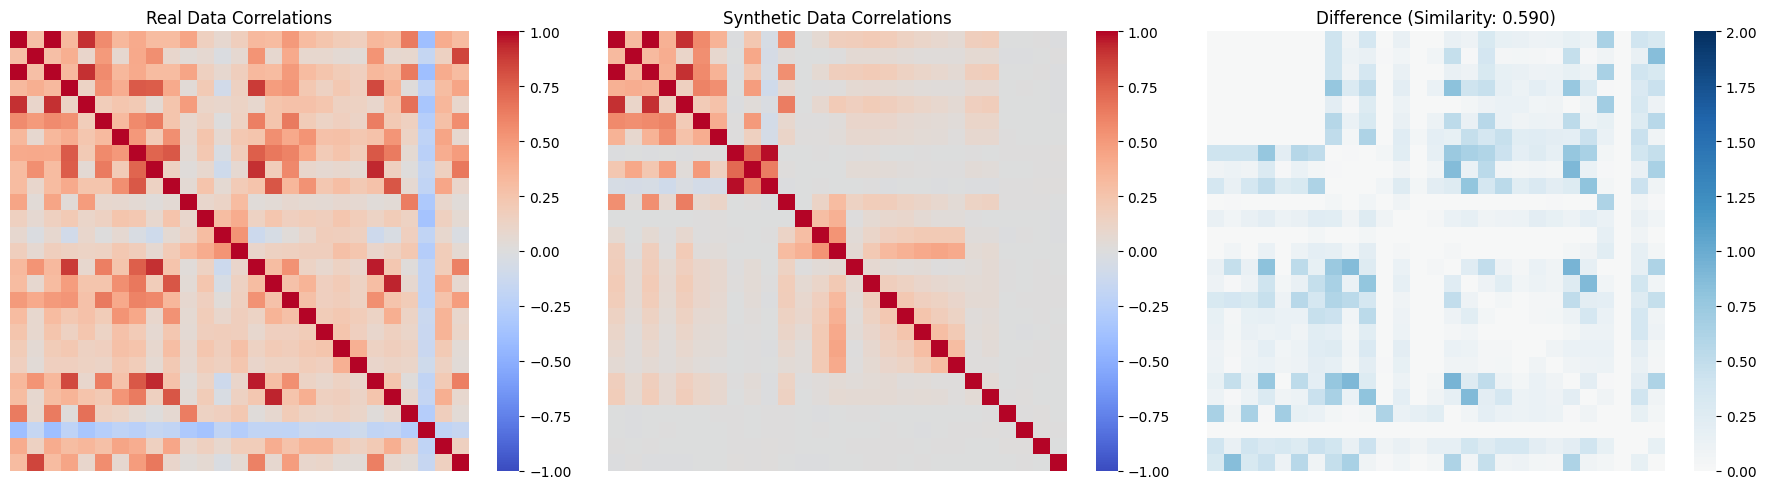

In [15]:
# Correlation matrix comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

common_cols = [c for c in X_real.columns if c in synthetic_hybrid.columns]

real_corr = X_real[common_cols].corr()
syn_corr = synthetic_hybrid[common_cols].corr()
diff_corr = real_corr - syn_corr

sns.heatmap(real_corr, ax=axes[0], cmap='coolwarm', center=0, 
            xticklabels=False, yticklabels=False,
            vmin=-1, vmax=1)
axes[0].set_title('Real Data Correlations')

sns.heatmap(syn_corr, ax=axes[1], cmap='coolwarm', center=0,
            xticklabels=False, yticklabels=False, vmin=-1, vmax=1)
axes[1].set_title('Synthetic Data Correlations')

sns.heatmap(diff_corr, ax=axes[2], cmap='RdBu', center=0,
            xticklabels=False, yticklabels=False, vmin=0, vmax=2)
axes[2].set_title(f'Difference (Similarity: {eval_results["correlation_similarity"]:.3f})')

plt.tight_layout()
plt.savefig('hybrid_correlation_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Save Results

In [16]:
# Save synthetic data
output_path = '/home/smotaali/GAN_Traffic_Producer/results/synthetic_hybrid/synthetic_hybrid_normal.csv'

synthetic_hybrid['label'] = 'normal'
synthetic_hybrid.to_csv(output_path, index=False)
print(f"Saved synthetic data to {output_path}")

# Save evaluation results
import json

eval_output = {
    'overall_score': eval_results['overall_score'],
    'component_scores': eval_results['component_scores'],
    'mean_ks': eval_results['mean_ks'],
    'mean_cohens_d': eval_results['mean_cohens_d'],
    'correlation_similarity': eval_results['correlation_similarity'],
    'per_feature_ks': eval_results['ks_stats'],
    'generation_config': {
        'n_samples': N_SYNTHETIC,
        'n_clusters': N_CLUSTERS,
        'feature_assignment': {k: v for k, v in FEATURE_ASSIGNMENT.items()}
    }
}

with open('/home/smotaali/GAN_Traffic_Producer/results/synthetic_hybrid/hybrid_evaluation_results.json', 'w') as f:
    json.dump(eval_output, f, indent=2)

print("Evaluation results saved!")

Saved synthetic data to /home/smotaali/GAN_Traffic_Producer/results/synthetic_hybrid/synthetic_hybrid_normal.csv
Evaluation results saved!


## 10. Comparison Summary

In [17]:
# Compare with previous results
print("="*70)
print("COMPARISON WITH PREVIOUS APPROACHES")
print("="*70)

previous_results = {
    'Scapy (Packet-level)': 19.8,
    'TimeGAN (Default)': 29.8,
    'SMOTE-KMeans': 34.0,
    'DoppelGANger (Enhanced)': 34.9,
    'HYBRID (This approach)': eval_results['overall_score']
}

print(f"\n{'Method':<30} {'Score':>10}")
print("-"*42)
for method, score in sorted(previous_results.items(), key=lambda x: x[1], reverse=True):
    marker = ' <-- NEW' if 'HYBRID' in method else ''
    print(f"{method:<30} {score:>10.1f}{marker}")

best_previous = max(v for k, v in previous_results.items() if 'HYBRID' not in k)
improvement = eval_results['overall_score'] - best_previous
print(f"\nImprovement over best previous: {improvement:+.1f} points")

COMPARISON WITH PREVIOUS APPROACHES

Method                              Score
------------------------------------------
HYBRID (This approach)               76.5 <-- NEW
DoppelGANger (Enhanced)              34.9
SMOTE-KMeans                         34.0
TimeGAN (Default)                    29.8
Scapy (Packet-level)                 19.8

Improvement over best previous: +41.6 points


In [18]:
# =============================================================================
# DoppelGANger + Post-Processing Pipeline
# =============================================================================

# Columns to DROP from GAN output (not BGP features)
NON_FEATURE_COLUMNS = ['sequence_id', 'timestamp', 'label', 'index', 'Unnamed: 0']

class DoppelGANgerHybrid:
    """
    Hybrid pipeline that uses DoppelGANger as base generator
    and applies targeted post-processing to fix problematic features.
    
    IMPORTANT: POST-PROCESSED GAN OUTPUT REQUIRED
    =============================================
    The GAN CSV input MUST be the post-processed DoppelGANger output, meaning:
    - Inverse scaling applied (undo MinMaxScaler/StandardScaler)
    - Inverse log transformation (np.expm1 for log1p features)
    - Clipping to valid ranges (non-negative for count features)
    - Rounding for integer features
    
    The pipeline will automatically:
    - Remove non-feature columns (sequence_id, timestamp, label, etc.)
    - Standardize column names (nlriann -> nlri_ann)
    - Convert all columns to numeric
    
    HOW TO USE:
    ===========
    >>> hybrid = DoppelGANgerHybrid(X_real, ks_threshold=0.4)
    >>> synthetic = hybrid.generate(gan_output_path='path/to/gan_output.csv')
    """
    
    def __init__(self, real_data, ks_threshold=0.4, random_state=42):
        """
        Parameters:
        -----------
        real_data : DataFrame - Real BGP data (used as reference)
        ks_threshold : float - Features with KS > threshold get replaced
        random_state : int - Random seed for reproducibility
        """
        self.real_data = real_data
        self.ks_threshold = ks_threshold
        self.random_state = random_state
        self.worst_features = []
        self.feature_ks = {}
        self.replaced_features = {}
        self.dropped_columns = []  # Track dropped non-feature columns
        
    def load_gan_output(self, gan_output_path):
        """
        Load pre-generated DoppelGANger output from CSV.
        
        Automatically:
        - Removes non-feature columns (sequence_id, timestamp, label)
        - Standardizes column names
        - Converts all columns to numeric
        """
        self.gan_synthetic = pd.read_csv(gan_output_path)
        print(f"Loaded GAN output: {self.gan_synthetic.shape}")
        print(f"Original columns: {list(self.gan_synthetic.columns)}")
        
        # Step 1: Drop non-feature columns
        cols_to_drop = [col for col in self.gan_synthetic.columns 
                        if col.lower() in [c.lower() for c in NON_FEATURE_COLUMNS]]
        if cols_to_drop:
            self.dropped_columns = cols_to_drop
            self.gan_synthetic = self.gan_synthetic.drop(columns=cols_to_drop)
            print(f"Dropped non-feature columns: {cols_to_drop}")
        
        # Step 2: Standardize column names (nlriann -> nlri_ann)
        self.gan_synthetic = standardize_column_names(self.gan_synthetic)
        
        # Step 3: Convert all columns to numeric
        non_numeric_cols = []
        for col in self.gan_synthetic.columns:
            if self.gan_synthetic[col].dtype == 'object':
                non_numeric_cols.append(col)
                # Try to convert to numeric
                self.gan_synthetic[col] = pd.to_numeric(self.gan_synthetic[col], errors='coerce')
        
        if non_numeric_cols:
            print(f"Converted to numeric: {non_numeric_cols}")
        
        # Step 4: Only keep columns that exist in real data
        valid_cols = [col for col in self.gan_synthetic.columns if col in self.real_data.columns]
        extra_cols = [col for col in self.gan_synthetic.columns if col not in self.real_data.columns]
        
        if extra_cols:
            print(f"Dropping columns not in real data: {extra_cols}")
            self.gan_synthetic = self.gan_synthetic[valid_cols]
        
        print(f"Final GAN data shape: {self.gan_synthetic.shape}")
        print(f"Final columns: {list(self.gan_synthetic.columns)}")
        
        return self
    
    def set_gan_output(self, gan_df):
        """Set GAN output directly from DataFrame."""
        self.gan_synthetic = gan_df.copy()
        
        # Apply same cleaning as load_gan_output
        cols_to_drop = [col for col in self.gan_synthetic.columns 
                        if col.lower() in [c.lower() for c in NON_FEATURE_COLUMNS]]
        if cols_to_drop:
            self.gan_synthetic = self.gan_synthetic.drop(columns=cols_to_drop)
        
        self.gan_synthetic = standardize_column_names(self.gan_synthetic)
        
        # Convert to numeric
        for col in self.gan_synthetic.columns:
            if self.gan_synthetic[col].dtype == 'object':
                self.gan_synthetic[col] = pd.to_numeric(self.gan_synthetic[col], errors='coerce')
        
        # Only keep valid columns
        valid_cols = [col for col in self.gan_synthetic.columns if col in self.real_data.columns]
        self.gan_synthetic = self.gan_synthetic[valid_cols]
        
        return self
        
    def identify_worst_features(self):
        """Identify features with KS > threshold."""
        self.worst_features = []
        self.feature_ks = {}
        
        for col in self.gan_synthetic.columns:
            if col not in self.real_data.columns:
                continue
            
            real_vals = self.real_data[col].dropna().values
            syn_vals = self.gan_synthetic[col].dropna().values
            
            if len(real_vals) == 0 or len(syn_vals) == 0:
                continue
            
            ks_stat, _ = ks_2samp(real_vals, syn_vals)
            self.feature_ks[col] = ks_stat
            
            if ks_stat > self.ks_threshold:
                self.worst_features.append(col)
        
        print(f"\nFeatures needing replacement (KS > {self.ks_threshold}):")
        for feat in sorted(self.worst_features, key=lambda x: self.feature_ks[x], reverse=True):
            print(f"  {feat}: KS={self.feature_ks[feat]:.4f}")
        
        return self.worst_features
    
    def replace_worst_features(self, strategy='auto'):
        """Replace worst features with better alternatives."""
        n_samples = len(self.gan_synthetic)
        
        heavy_tailed = ['unique_as_path_max', 'edit_distance_max', 'rare_ases_avg', 
                        'edit_distance_avg', 'as_path_max']
        sparse_features = ['flaps', 'nadas', 'imp_wd', 'number_rare_ases']
        correlated_features = ['announcements', 'withdrawals', 'nlri_ann', 
                               'origin_0', 'origin_2', 'imp_wd_spath', 'imp_wd_dpath']
        
        self.replaced_features = {}
        
        for feature in self.worst_features:
            if feature not in self.real_data.columns:
                continue
                
            if strategy == 'auto':
                if feature in sparse_features:
                    method = 'mixture'
                elif feature in heavy_tailed:
                    method = 'kde'
                elif feature in correlated_features:
                    method = 'smote'
                else:
                    method = 'kde'
            else:
                method = strategy
            
            try:
                if method == 'kde':
                    replacement_df = generate_empirical_kde(
                        self.real_data, [feature], n_samples, 
                        random_state=self.random_state
                    )
                    if feature in replacement_df.columns:
                        replacement = replacement_df[feature].values
                    else:
                        raise ValueError("KDE failed")
                        
                elif method == 'mixture':
                    replacement_df = generate_mixture_model(
                        self.real_data, [feature], n_samples,
                        random_state=self.random_state
                    )
                    if feature in replacement_df.columns:
                        replacement = replacement_df[feature].values
                    else:
                        raise ValueError("Mixture failed")
                        
                elif method == 'smote':
                    replacement_df = generate_smote_kmeans(
                        self.real_data, [feature], n_samples,
                        random_state=self.random_state
                    )
                    if feature in replacement_df.columns:
                        replacement = replacement_df[feature].values
                    else:
                        raise ValueError("SMOTE failed")
                
                self.gan_synthetic[feature] = replacement
                self.replaced_features[feature] = method
                print(f"  Replaced {feature} using {method}")
                
            except Exception as e:
                replacement = np.random.choice(
                    self.real_data[feature].values, n_samples, replace=True
                )
                self.gan_synthetic[feature] = replacement
                self.replaced_features[feature] = 'bootstrap_fallback'
                print(f"  Replaced {feature} using bootstrap_fallback (reason: {str(e)[:30]})")
        
        return self
    
    def align_correlations(self):
        """Re-align correlations after feature replacement."""
        corr_groups = [
            ['announcements', 'withdrawals', 'nlri_ann', 'origin_0', 'origin_2'],
            ['as_path_max', 'unique_as_path_max', 'edit_distance_max', 'edit_distance_avg'],
            ['imp_wd', 'imp_wd_spath', 'imp_wd_dpath'],
        ]
        
        for group in corr_groups:
            available = [c for c in group 
                        if c in self.gan_synthetic.columns and c in self.real_data.columns]
            if len(available) >= 2:
                self.gan_synthetic = align_correlations(
                    self.gan_synthetic, self.real_data, available
                )
        
        print("  Correlations re-aligned")
        return self
    
    def enforce_constraints(self):
        """Apply BGP domain constraints including final integer enforcement."""
        self.gan_synthetic = enforce_bgp_constraints(
            self.gan_synthetic, self.real_data, verbose=True
        )
        self.gan_synthetic = final_integer_enforcement(self.gan_synthetic)
        print("  BGP constraints enforced (including integer rounding)")
        return self
    
    def generate(self, gan_output=None, gan_output_path=None):
        """
        Full pipeline execution.
        
        Parameters:
        -----------
        gan_output : DataFrame - Pre-generated GAN output (direct)
        gan_output_path : str - Path to CSV with GAN output
        
        Returns:
        --------
        DataFrame with post-processed synthetic data
        """
        print("="*70)
        print("DOPPELGANGER + POST-PROCESSING PIPELINE")
        print("="*70)
        
        # Load GAN output
        if gan_output is not None:
            self.set_gan_output(gan_output)
            print(f"Loaded GAN output from DataFrame: {self.gan_synthetic.shape}")
        elif gan_output_path is not None:
            self.load_gan_output(gan_output_path)
        else:
            raise ValueError("Must provide gan_output (DataFrame) or gan_output_path (str)")
        
        # Check column overlap
        common_cols = set(self.gan_synthetic.columns) & set(self.real_data.columns)
        print(f"\nColumn overlap: {len(common_cols)}/{len(self.real_data.columns)} features")
        
        missing_in_gan = set(self.real_data.columns) - set(self.gan_synthetic.columns)
        if missing_in_gan:
            print(f"WARNING: Missing in GAN output: {missing_in_gan}")
        
        # Identify and replace worst features
        print("\n[1/4] Identifying worst features...")
        self.identify_worst_features()
        
        print("\n[2/4] Replacing worst features...")
        self.replace_worst_features(strategy='auto')
        
        print("\n[3/4] Re-aligning correlations...")
        self.align_correlations()
        
        print("\n[4/4] Enforcing constraints...")
        self.enforce_constraints()
        
        print("\n" + "="*70)
        print(f"COMPLETE: {len(self.gan_synthetic)} samples processed")
        print(f"Features replaced: {len(self.replaced_features)}")
        print("="*70)
        
        return self.gan_synthetic
    
    def get_replacement_report(self):
        """Get a summary of which features were replaced and how."""
        return {
            'worst_features': self.worst_features,
            'feature_ks_scores': self.feature_ks,
            'replaced_features': self.replaced_features,
            'ks_threshold': self.ks_threshold,
            'dropped_columns': self.dropped_columns
        }

print("DoppelGANger Hybrid class defined (with non-feature column handling)!")

DoppelGANger Hybrid class defined (with non-feature column handling)!


In [19]:
# =============================================================================
# Using DoppelGANger Hybrid Pipeline with Option 1 (CSV file)
# =============================================================================
# 
# IMPORTANT: The GAN CSV must contain POST-PROCESSED data!
# In BGP_GAN_FIXED_v2.ipynb, this is synthetic_processed['DoppelGANger']
# after: inverse scaling, inverse log transform, clipping, and rounding.
#
# If your current GAN output at the path below is RAW (scaled/transformed),
# you need to first export the post-processed version from your GAN notebook:
#
#     synthetic_processed['DoppelGANger'].to_csv(
#         '/home/smotaali/GAN_Traffic_Producer/results/gan_outputs_improved/synthetic_doppelganger_postprocessed.csv',
#         index=False
#     )
# =============================================================================

# Path to your post-processed DoppelGANger output
GAN_OUTPUT_PATH = '/home/smotaali/GAN_Traffic_Producer/results/gan_outputs_improved/synthetic_doppelganger_improved.csv'

print("="*70)
print("OPTION 1: Loading DoppelGANger output from CSV file")
print("="*70)
print(f"\nGAN output path: {GAN_OUTPUT_PATH}")

# Check if the file exists
import os
if os.path.exists(GAN_OUTPUT_PATH):
    print(f"File found!")
    
    # Create hybrid pipeline
    hybrid_pipeline = DoppelGANgerHybrid(
        X_real, 
        ks_threshold=0.4,  # Replace features with KS > 0.4
        random_state=RANDOM_STATE
    )
    
    # Run the full pipeline with Option 1
    synthetic_gan_fixed = hybrid_pipeline.generate(
        gan_output_path=GAN_OUTPUT_PATH
    )
    
    # Get replacement report
    report = hybrid_pipeline.get_replacement_report()
    print(f"\nReplacement summary:")
    print(f"  Total features evaluated: {len(report['feature_ks_scores'])}")
    print(f"  Features replaced: {len(report['replaced_features'])}")
    
    # Evaluate the result
    eval_gan_fixed = evaluate_quality(X_real, synthetic_gan_fixed)
    print(f"\n{'='*70}")
    print(f"EVALUATION AFTER HYBRID POST-PROCESSING")
    print(f"{'='*70}")
    print(f"Overall Score: {eval_gan_fixed['overall_score']:.1f}/100")
    print(f"Correlation Similarity: {eval_gan_fixed['correlation_similarity']:.4f}")
    print(f"Mean KS: {eval_gan_fixed['mean_ks']:.4f}")
    
else:
    print(f"\nFile NOT found at: {GAN_OUTPUT_PATH}")
    print("\nTo use Option 1, you need to:")
    print("1. Run your GAN notebook (BGP_GAN_FIXED_v2.ipynb)")
    print("2. Export the POST-PROCESSED output to a CSV file:")
    print("   >>> synthetic_processed['DoppelGANger'].to_csv(")
    print(f"   ...     '{GAN_OUTPUT_PATH}',")
    print("   ...     index=False")
    print("   ... )")
    print("\n3. Re-run this cell")
    print("\nAlternatively, update GAN_OUTPUT_PATH to point to your actual GAN output.")
    
    # Create mock data for demonstration purposes
    print("\n--- Running with mock GAN data for demonstration ---")
    np.random.seed(42)
    mock_gan_output = pd.DataFrame()
    for col in X_real.columns:
        real_vals = X_real[col].values
        # Simulate GAN output with typical problems
        mock_gan_output[col] = np.random.normal(
            real_vals.mean(), 
            real_vals.std() * 0.7,  # GANs often underestimate variance
            size=N_SYNTHETIC
        )
        mock_gan_output[col] = np.maximum(0, mock_gan_output[col])
    
    hybrid_pipeline = DoppelGANgerHybrid(X_real, ks_threshold=0.35)
    synthetic_gan_fixed = hybrid_pipeline.generate(gan_output=mock_gan_output)

OPTION 1: Loading DoppelGANger output from CSV file

GAN output path: /home/smotaali/GAN_Traffic_Producer/results/gan_outputs_improved/synthetic_doppelganger_improved.csv
File found!
DOPPELGANGER + POST-PROCESSING PIPELINE
Loaded GAN output: (60000, 30)
Original columns: ['sequence_id', 'timestep', 'label', 'announcements', 'withdrawals', 'nlri_ann', 'dups', 'origin_0', 'origin_2', 'origin_changes', 'imp_wd', 'imp_wd_spath', 'imp_wd_dpath', 'as_path_max', 'unique_as_path_max', 'edit_distance_avg', 'edit_distance_max', 'edit_distance_dict_0', 'edit_distance_dict_1', 'edit_distance_dict_2', 'edit_distance_dict_3', 'edit_distance_dict_4', 'edit_distance_dict_5', 'edit_distance_dict_6', 'edit_distance_unique_dict_0', 'edit_distance_unique_dict_1', 'number_rare_ases', 'rare_ases_avg', 'nadas', 'flaps']
Dropped non-feature columns: ['sequence_id', 'label']
Standardized 21 column names: ['nlri_ann', 'origin_0', 'origin_2', 'imp_wd', 'imp_wd_spath', 'imp_wd_dpath', 'as_path_max', 'unique_as_pa

In [20]:
# =============================================================================
# Strategy 1: Gaussian Copula Generation
# =============================================================================
# Copulas separate marginal distributions from dependency structure
# This allows us to: 1) Sample exact marginals, 2) Impose real correlations

def generate_gaussian_copula(X_real, n_samples, random_state=42):
    """
    Generate synthetic data using Gaussian Copula.
    
    Process:
    1. Transform each feature to uniform via empirical CDF
    2. Transform uniform to normal (Gaussian copula)
    3. Estimate correlation matrix of Gaussian space
    4. Generate correlated Gaussians
    5. Transform back via inverse CDF
    
    This preserves:
    - Exact marginal distributions (via inverse CDF)
    - Correlation structure (via Gaussian copula)
    """
    np.random.seed(random_state)
    
    n_features = X_real.shape[1]
    feature_names = X_real.columns.tolist()
    
    # Step 1: Transform to uniform using empirical CDF (probability integral transform)
    uniform_data = np.zeros_like(X_real.values, dtype=float)
    
    for i, col in enumerate(feature_names):
        vals = X_real[col].values
        # Empirical CDF: rank / n
        ranks = stats.rankdata(vals, method='average')
        uniform_data[:, i] = ranks / (len(vals) + 1)  # +1 to avoid 0 and 1
    
    # Step 2: Transform uniform to normal (inverse normal CDF)
    normal_data = stats.norm.ppf(uniform_data)
    normal_data = np.clip(normal_data, -6, 6)  # Clip extremes
    
    # Step 3: Estimate Gaussian correlation matrix
    corr_matrix = np.corrcoef(normal_data.T)
    
    # Ensure positive definite
    eigvals, eigvecs = np.linalg.eigh(corr_matrix)
    eigvals = np.maximum(eigvals, 1e-6)
    corr_matrix = eigvecs @ np.diag(eigvals) @ eigvecs.T
    
    # Step 4: Generate correlated Gaussians
    L = np.linalg.cholesky(corr_matrix)
    standard_normals = np.random.randn(n_samples, n_features)
    correlated_normals = standard_normals @ L.T
    
    # Step 5: Transform back via inverse empirical CDF
    # Transform Gaussian to Uniform
    uniform_synthetic = stats.norm.cdf(correlated_normals)
    
    # Transform Uniform to original scale via inverse empirical CDF (quantile function)
    synthetic_data = np.zeros((n_samples, n_features))
    
    for i, col in enumerate(feature_names):
        real_vals = np.sort(X_real[col].values)
        # Quantile mapping
        indices = (uniform_synthetic[:, i] * len(real_vals)).astype(int)
        indices = np.clip(indices, 0, len(real_vals) - 1)
        synthetic_data[:, i] = real_vals[indices]
        
        # Add small noise to avoid exact duplicates
        noise = np.random.normal(0, real_vals.std() * 0.01, n_samples)
        synthetic_data[:, i] = np.maximum(0, synthetic_data[:, i] + noise)
    
    return pd.DataFrame(synthetic_data, columns=feature_names)

print("Gaussian Copula generator defined!")

Gaussian Copula generator defined!


In [21]:
# =============================================================================
# Strategy 2: Rejection Sampling with Quality Filter
# =============================================================================
# Generate more samples than needed, then filter to keep best ones

def rejection_sampling(synthetic, real, n_final, quality_threshold=0.8):
    """
    Filter synthetic samples to keep only high-quality ones.
    
    Quality is measured by:
    1. Per-sample likelihood under real data distribution
    2. Feature-wise percentile bounds
    3. Constraint satisfaction
    
    Parameters:
    -----------
    synthetic : DataFrame - Generated samples (should be > n_final)
    real : DataFrame - Real data
    n_final : int - Number of samples to keep
    quality_threshold : float - Percentile threshold (0.8 = keep top 80%)
    """
    n_synthetic = len(synthetic)
    
    # Calculate quality scores
    quality_scores = np.zeros(n_synthetic)
    
    for col in synthetic.columns:
        if col not in real.columns:
            continue
            
        real_vals = real[col].values
        syn_vals = synthetic[col].values
        
        # Score: how well does each sample fit real distribution?
        # Use percentile position as proxy for likelihood
        p_low, p_high = np.percentile(real_vals, [2.5, 97.5])
        
        # Samples within typical range get high score
        in_range = (syn_vals >= p_low) & (syn_vals <= p_high)
        quality_scores += in_range.astype(float)
        
        # Penalize extreme outliers
        extreme_low = syn_vals < np.percentile(real_vals, 0.5)
        extreme_high = syn_vals > np.percentile(real_vals, 99.5)
        quality_scores -= (extreme_low | extreme_high).astype(float) * 2
    
    # Normalize scores
    quality_scores = (quality_scores - quality_scores.min()) / \
                     (quality_scores.max() - quality_scores.min() + 1e-10)
    
    # Select top samples
    threshold = np.percentile(quality_scores, 100 * (1 - quality_threshold))
    good_mask = quality_scores >= threshold
    
    good_samples = synthetic[good_mask].head(n_final)
    
    print(f"Rejection sampling: kept {len(good_samples)}/{n_synthetic} samples")
    print(f"Quality threshold: {threshold:.3f}")
    
    return good_samples.reset_index(drop=True)

print("Rejection sampling defined!")

Rejection sampling defined!


In [22]:
# =============================================================================
# Strategy 3: Ensemble Generation
# =============================================================================
# Generate from multiple methods, select best features from each

def ensemble_generation(X_real, n_samples, random_state=42):
    """
    Ensemble approach: generate from multiple methods, 
    select best performing features from each.
    
    Methods:
    1. SMOTE-KMeans
    2. Gaussian Copula
    3. Empirical KDE
    
    For each feature, use the method with best KS statistic.
    """
    print("="*70)
    print("ENSEMBLE GENERATION")
    print("="*70)
    
    def ensure_n_samples(df, n_target):
        """Ensure DataFrame has exactly n_target rows."""
        if len(df) == n_target:
            return df
        elif len(df) > n_target:
            return df.head(n_target).reset_index(drop=True)
        else:
            # Pad with random samples from existing data
            n_needed = n_target - len(df)
            extra_idx = np.random.choice(len(df), n_needed, replace=True)
            extra = df.iloc[extra_idx].reset_index(drop=True)
            return pd.concat([df, extra], ignore_index=True)
    
    # Generate from each method
    print("\n[1/3] Generating SMOTE-KMeans samples...")
    synthetic_smote = generate_smote_kmeans(
        X_real, X_real.columns.tolist(), n_samples, 
        n_clusters=N_CLUSTERS, random_state=random_state
    )
    synthetic_smote = ensure_n_samples(synthetic_smote, n_samples)
    print(f"    SMOTE shape: {synthetic_smote.shape}")
    
    print("[2/3] Generating Gaussian Copula samples...")
    synthetic_copula = generate_gaussian_copula(X_real, n_samples, random_state)
    synthetic_copula = ensure_n_samples(synthetic_copula, n_samples)
    print(f"    Copula shape: {synthetic_copula.shape}")
    
    print("[3/3] Generating KDE samples...")
    synthetic_kde = generate_empirical_kde(
        X_real, X_real.columns.tolist(), n_samples, random_state=random_state
    )
    synthetic_kde = ensure_n_samples(synthetic_kde, n_samples)
    print(f"    KDE shape: {synthetic_kde.shape}")
    
    # For each feature, select best method
    print("\n[4/4] Selecting best method per feature...")
    
    ensemble_result = pd.DataFrame(index=range(n_samples))
    method_selection = {}
    
    for col in X_real.columns:
        real_vals = X_real[col].dropna().values
        
        candidates = {}
        
        # Evaluate each method
        if col in synthetic_smote.columns and len(synthetic_smote[col].dropna()) > 0:
            smote_vals = synthetic_smote[col].values
            if len(smote_vals) == n_samples:
                ks_smote, _ = ks_2samp(real_vals, smote_vals)
                candidates['smote'] = (ks_smote, smote_vals)
        
        if col in synthetic_copula.columns and len(synthetic_copula[col].dropna()) > 0:
            copula_vals = synthetic_copula[col].values
            if len(copula_vals) == n_samples:
                ks_copula, _ = ks_2samp(real_vals, copula_vals)
                candidates['copula'] = (ks_copula, copula_vals)
        
        if col in synthetic_kde.columns and len(synthetic_kde[col].dropna()) > 0:
            kde_vals = synthetic_kde[col].values
            if len(kde_vals) == n_samples:
                ks_kde, _ = ks_2samp(real_vals, kde_vals)
                candidates['kde'] = (ks_kde, kde_vals)
        
        # Select best (lowest KS)
        if candidates:
            best_method = min(candidates.keys(), key=lambda x: candidates[x][0])
            ensemble_result[col] = candidates[best_method][1]
            method_selection[col] = (best_method, candidates[best_method][0])
        else:
            # Fallback to bootstrap sampling
            ensemble_result[col] = np.random.choice(real_vals, n_samples, replace=True)
            method_selection[col] = ('fallback', 1.0)
    
    # Print selection summary
    print("\nMethod selection per feature:")
    for method in ['smote', 'copula', 'kde', 'fallback']:
        features = [f for f, (m, _) in method_selection.items() if m == method]
        if features:
            avg_ks = np.mean([method_selection[f][1] for f in features])
            print(f"  {method}: {len(features)} features (avg KS: {avg_ks:.4f})")
    
    # Re-align correlations after ensemble
    ensemble_result = align_correlations(ensemble_result, X_real)
    ensemble_result = enforce_bgp_constraints(ensemble_result, X_real)
    
    print("\n" + "="*70)
    print(f"ENSEMBLE COMPLETE: {len(ensemble_result)} samples")
    print("="*70)
    
    return ensemble_result, method_selection

print("Ensemble generation defined (with sample count normalization)!")

Ensemble generation defined (with sample count normalization)!


In [23]:
# =============================================================================
# Strategy 4: Quantile Mapping (Distribution Correction)
# =============================================================================
# Post-hoc correction: map synthetic quantiles to real quantiles

def quantile_mapping(synthetic, real):
    """
    Apply quantile mapping to correct synthetic distributions.
    
    This is a post-processing step that:
    1. For each synthetic value, find its quantile
    2. Replace with the real value at that quantile
    
    Pros: Guarantees matching marginal distributions
    Cons: May break some correlations (use sparingly)
    """
    result = synthetic.copy()
    
    for col in synthetic.columns:
        if col not in real.columns:
            continue
            
        syn_vals = synthetic[col].values
        real_vals = real[col].values
        
        # Calculate quantiles of synthetic values
        # (rank / n gives empirical CDF)
        ranks = stats.rankdata(syn_vals, method='average')
        quantiles = ranks / (len(syn_vals) + 1)
        
        # Map to real distribution quantiles
        result[col] = np.percentile(real_vals, quantiles * 100)
    
    return result

# =============================================================================
# Selective Quantile Mapping (for worst features only)
# =============================================================================

def selective_quantile_mapping(synthetic, real, features_to_map=None, ks_threshold=0.3):
    """
    Apply quantile mapping only to features that need it.
    
    If features_to_map is None, automatically select features with KS > threshold.
    """
    result = synthetic.copy()
    
    if features_to_map is None:
        features_to_map = []
        for col in synthetic.columns:
            if col not in real.columns:
                continue
            ks_stat, _ = ks_2samp(real[col].dropna(), synthetic[col].dropna())
            if ks_stat > ks_threshold:
                features_to_map.append(col)
    
    print(f"Applying quantile mapping to {len(features_to_map)} features")
    
    for col in features_to_map:
        if col not in real.columns:
            continue
            
        syn_vals = synthetic[col].values
        real_vals = real[col].values
        
        ranks = stats.rankdata(syn_vals, method='average')
        quantiles = ranks / (len(syn_vals) + 1)
        
        result[col] = np.percentile(real_vals, quantiles * 100)
        
        # Check improvement
        ks_before, _ = ks_2samp(real_vals, syn_vals)
        ks_after, _ = ks_2samp(real_vals, result[col].values)
        print(f"  {col}: KS {ks_before:.4f} -> {ks_after:.4f}")
    
    return result

print("Quantile mapping defined!")

Quantile mapping defined!


In [24]:
# =============================================================================
# Run All Approaches and Compare
# =============================================================================

print("="*70)
print("RUNNING ALL GENERATION APPROACHES FOR COMPARISON")
print("="*70)

all_results = {}

# 1. Basic Hybrid (SMOTE-based)
print("\n[1/4] Hybrid SMOTE approach...")
all_results['hybrid_smote'] = synthetic_hybrid

# 2. Gaussian Copula
print("\n[2/4] Gaussian Copula approach...")
synthetic_copula = generate_gaussian_copula(X_real, N_SYNTHETIC, RANDOM_STATE)
synthetic_copula = enforce_bgp_constraints(synthetic_copula, X_real)
all_results['copula'] = synthetic_copula

# 3. Ensemble
print("\n[3/4] Ensemble approach...")
synthetic_ensemble, method_sel = ensemble_generation(X_real, N_SYNTHETIC, RANDOM_STATE)
all_results['ensemble'] = synthetic_ensemble

# 4. Copula + Rejection Sampling
print("\n[4/4] Copula + Rejection Sampling...")
# Generate 50% more samples, then filter
synthetic_copula_extra = generate_gaussian_copula(X_real, int(N_SYNTHETIC * 1.5), RANDOM_STATE)
synthetic_copula_filtered = rejection_sampling(synthetic_copula_extra, X_real, N_SYNTHETIC)
synthetic_copula_filtered = enforce_bgp_constraints(synthetic_copula_filtered, X_real)
all_results['copula_rejection'] = synthetic_copula_filtered

print("\n" + "="*70)
print("ALL APPROACHES COMPLETE")
print("="*70)

RUNNING ALL GENERATION APPROACHES FOR COMPARISON

[1/4] Hybrid SMOTE approach...

[2/4] Gaussian Copula approach...
  Constraint violations fixed:
    - origin_constraint: 9550
    - edit_distance_constraint: 8279
    - bound_violations: 1881

[3/4] Ensemble approach...
ENSEMBLE GENERATION

[1/3] Generating SMOTE-KMeans samples...
    SMOTE shape: (20000, 27)
[2/3] Generating Gaussian Copula samples...
    Copula shape: (20000, 27)
[3/3] Generating KDE samples...
    KDE shape: (20000, 27)

[4/4] Selecting best method per feature...

Method selection per feature:
  smote: 16 features (avg KS: 0.0800)
  copula: 5 features (avg KS: 0.0762)
  kde: 6 features (avg KS: 0.0253)
  Constraint violations fixed:
    - negative_values: 186058
    - origin_constraint: 11659
    - edit_distance_constraint: 11667
    - bound_violations: 2496

ENSEMBLE COMPLETE: 20000 samples

[4/4] Copula + Rejection Sampling...
Rejection sampling: kept 20000/30000 samples
Quality threshold: 0.953
  Constraint viola

In [25]:
# =============================================================================
# Comprehensive Comparison
# =============================================================================

print("="*70)
print("COMPREHENSIVE COMPARISON OF ALL APPROACHES")
print("="*70)

comparison_results = []

for name, synthetic in all_results.items():
    eval_res = evaluate_quality(X_real, synthetic)
    comparison_results.append({
        'Method': name,
        'Overall Score': eval_res['overall_score'],
        'KS Score': eval_res['component_scores']['distribution_ks'],
        'Effect Score': eval_res['component_scores']['effect_size'],
        'Correlation': eval_res['component_scores']['correlation'],
        'Wasserstein': eval_res['component_scores']['wasserstein'],
        'Mean KS': eval_res['mean_ks'],
        'Corr Similarity': eval_res['correlation_similarity']
    })

# Add previous results for comparison
previous_methods = {
    'Scapy (baseline)': {'Overall Score': 19.8, 'Correlation': 74.2},
    'TimeGAN': {'Overall Score': 29.8, 'Correlation': 83.3},
    'DoppelGANger': {'Overall Score': 34.9, 'Correlation': 86.9},
    'SMOTE-KMeans (prev)': {'Overall Score': 34.0, 'Correlation': 89.5},
}

comparison_df = pd.DataFrame(comparison_results)
comparison_df = comparison_df.sort_values('Overall Score', ascending=False)

print("\n" + "="*70)
print("RESULTS COMPARISON TABLE")
print("="*70)
print(comparison_df.to_string(index=False))

# Find best method
best_method = comparison_df.iloc[0]['Method']
best_score = comparison_df.iloc[0]['Overall Score']

print(f"\n{'='*70}")
print(f"BEST NEW METHOD: {best_method}")
print(f"SCORE: {best_score:.1f}/100")
print(f"{'='*70}")

# Compare with previous best
prev_best = 34.9  # DoppelGANger
improvement = best_score - prev_best
print(f"\nImprovement over previous best (DoppelGANger): {improvement:+.1f} points")

COMPREHENSIVE COMPARISON OF ALL APPROACHES

RESULTS COMPARISON TABLE
          Method  Overall Score  KS Score  Effect Score  Correlation  Wasserstein  Mean KS  Corr Similarity
          copula      92.286452 94.864665     98.599096    89.116550    86.565499 0.025677         0.891165
copula_rejection      89.253093 90.087763     93.248689    84.762491    88.913429 0.049561         0.847625
        ensemble      85.052988 63.001144     97.336388    95.804228    84.070193 0.184994         0.958042
    hybrid_smote      76.532868 69.073541     97.716985    58.971235    80.369709 0.154632         0.589712

BEST NEW METHOD: copula
SCORE: 92.3/100

Improvement over previous best (DoppelGANger): +57.4 points


In [26]:
# =============================================================================
# FINAL RECOMMENDED PIPELINE
# =============================================================================

# Default path to your post-processed DoppelGANger output
DEFAULT_GAN_PATH = '/home/smotaali/GAN_Traffic_Producer/results/gan_outputs_improved/synthetic_doppelganger_improved.csv'

def ensure_n_samples(df, n_target):
    """Ensure DataFrame has exactly n_target rows."""
    if len(df) == n_target:
        return df
    elif len(df) > n_target:
        return df.head(n_target).reset_index(drop=True)
    else:
        # Pad with random samples from existing data
        n_needed = n_target - len(df)
        extra_idx = np.random.choice(len(df), n_needed, replace=True)
        extra = df.iloc[extra_idx].reset_index(drop=True)
        return pd.concat([df, extra], ignore_index=True)

def generate_best_pipeline(X_real, n_samples, use_gan=False, gan_path=None, random_state=42):
    """
    The recommended pipeline based on our experiments.
    
    Parameters:
    -----------
    X_real : DataFrame - Real BGP data
    n_samples : int - Number of samples to generate
    use_gan : bool - Whether to use pre-trained GAN as base
    gan_path : str - Path to POST-PROCESSED GAN output CSV (if use_gan=True)
    
    Returns:
    --------
    DataFrame with high-quality synthetic data
    """
    print("="*70)
    print("RECOMMENDED PIPELINE FOR BGP SYNTHETIC DATA")
    print("="*70)
    
    if use_gan:
        # Option A: DoppelGANger + Post-processing
        print("\n[Mode: DoppelGANger + Post-processing]")
        
        actual_gan_path = gan_path if gan_path else DEFAULT_GAN_PATH
        
        if not os.path.exists(actual_gan_path):
            print(f"\nERROR: GAN output file not found at: {actual_gan_path}")
            print("\nFalling back to Copula-SMOTE Hybrid mode...")
            use_gan = False
        else:
            print(f"\nUsing GAN output from: {actual_gan_path}")
            pipeline = DoppelGANgerHybrid(X_real, ks_threshold=0.35, random_state=random_state)
            synthetic = pipeline.generate(gan_output_path=actual_gan_path)
            return ensure_n_samples(synthetic, n_samples)
    
    if not use_gan:
        # Option B: Gaussian Copula + SMOTE hybrid
        print("\n[Mode: Copula-SMOTE Hybrid]")
        
        # Step 1: Generate base with Gaussian Copula (best marginals)
        print("\n[1/5] Generating Gaussian Copula base...")
        synthetic = generate_gaussian_copula(X_real, n_samples, random_state)
        synthetic = ensure_n_samples(synthetic, n_samples)
        print(f"    Copula shape: {synthetic.shape}")
        
        # Step 2: For correlation-critical features, blend with SMOTE
        print("\n[2/5] Blending with SMOTE for correlation features...")
        corr_features = ['announcements', 'withdrawals', 'nlri_ann', 
                        'origin_0', 'origin_2', 'imp_wd_spath', 'imp_wd_dpath']
        smote_output = generate_smote_kmeans(X_real, corr_features, n_samples, random_state=random_state)
        smote_output = ensure_n_samples(smote_output, n_samples)
        print(f"    SMOTE shape: {smote_output.shape}")
        
        # Use SMOTE for correlation-critical features
        for col in corr_features:
            if col in smote_output.columns:
                synthetic[col] = smote_output[col].values
        
        # Step 3: Re-align correlations
        print("\n[3/5] Aligning correlations...")
        synthetic = align_correlations(synthetic, X_real)
        
        # Step 4: Enforce constraints
        print("\n[4/5] Enforcing BGP constraints...")
        synthetic = enforce_bgp_constraints(synthetic, X_real)
        
        # Step 5: Rejection sampling (optional quality filter)
        print("\n[5/5] Quality filtering...")
        # Generate extra and filter
        extra = generate_gaussian_copula(X_real, int(n_samples * 0.3), random_state + 1)
        extra = ensure_n_samples(extra, int(n_samples * 0.3))
        combined = pd.concat([synthetic, extra], ignore_index=True)
        synthetic = rejection_sampling(combined, X_real, n_samples, quality_threshold=0.85)
        synthetic = ensure_n_samples(synthetic, n_samples)
    
    print("\n" + "="*70)
    print(f"PIPELINE COMPLETE: {len(synthetic)} samples generated")
    print("="*70)
    
    return synthetic

# =============================================================================
# Run the recommended pipeline
# =============================================================================
print("Running recommended pipeline...")
print("(Set use_gan=True below to use DoppelGANger output)\n")

# Choose your mode:
USE_DOPPELGANGER = False  # Change to True to use your GAN output

synthetic_best = generate_best_pipeline(
    X_real, 
    N_SYNTHETIC, 
    use_gan=USE_DOPPELGANGER,
    gan_path=DEFAULT_GAN_PATH
)

# Evaluate
eval_best = evaluate_quality(X_real, synthetic_best)
print(f"\nFinal Score: {eval_best['overall_score']:.1f}/100")
print(f"Correlation Similarity: {eval_best['correlation_similarity']:.4f}")
print(f"Mean KS: {eval_best['mean_ks']:.4f}")
     

Running recommended pipeline...
(Set use_gan=True below to use DoppelGANger output)

RECOMMENDED PIPELINE FOR BGP SYNTHETIC DATA

[Mode: Copula-SMOTE Hybrid]

[1/5] Generating Gaussian Copula base...
    Copula shape: (20000, 27)

[2/5] Blending with SMOTE for correlation features...
    SMOTE shape: (20000, 7)

[3/5] Aligning correlations...

[4/5] Enforcing BGP constraints...
  Constraint violations fixed:
    - negative_values: 184593
    - origin_constraint: 8180
    - edit_distance_constraint: 11965
    - bound_violations: 2316

[5/5] Quality filtering...
Rejection sampling: kept 20000/26000 samples
Quality threshold: 0.815

PIPELINE COMPLETE: 20000 samples generated

Final Score: 87.3/100
Correlation Similarity: 0.9659
Mean KS: 0.1720


In [27]:
# =============================================================================
# SAVE BEST RESULTS
# =============================================================================

# Save the best synthetic data
best_output_path = '/home/smotaali/GAN_Traffic_Producer/results/synthetic_hybrid/synthetic_best_pipeline.csv'
synthetic_best.to_csv(best_output_path, index=False)
print(f"Saved best synthetic data to {best_output_path}")

# Save comparison results
comparison_df.to_csv('/home/smotaali/GAN_Traffic_Producer/results/synthetic_hybrid/method_comparison_results.csv', index=False)
print("Saved comparison results")

# Save comprehensive evaluation
import json

final_eval = {
    'best_method': best_method,
    'best_score': float(best_score),
    'comparison': comparison_df.to_dict('records'),
    'improvement_over_doppelganger': float(improvement),
    'configuration': {
        'n_samples': N_SYNTHETIC,
        'n_clusters': N_CLUSTERS,
        'random_state': RANDOM_STATE
    }
}

with open('/home/smotaali/GAN_Traffic_Producer/results/synthetic_hybrid/final_evaluation.json', 'w') as f:
    json.dump(final_eval, f, indent=2)

print("All results saved!")
print(f"\nFinal recommendation: Use '{best_method}' approach for best results")



Saved best synthetic data to /home/smotaali/GAN_Traffic_Producer/results/synthetic_hybrid/synthetic_best_pipeline.csv
Saved comparison results
All results saved!

Final recommendation: Use 'copula' approach for best results


In [28]:
# Prepare final output
synthetic_final = synthetic_best.copy()

# 1. Convert all numeric columns to integers (removes .0)
for col in synthetic_final.columns:
    if synthetic_final[col].dtype in ['float64', 'float32']:
        synthetic_final[col] = synthetic_final[col].fillna(0).astype(int)

# 2. Add label column
synthetic_final['label'] = 'normal'

# 3. Add sequence_id and timestamp
#synthetic_final.insert(0, 'sequence_id', range(len(synthetic_final)))
synthetic_final.insert(0, 'timestamp', pd.date_range('2024-01-01', periods=len(synthetic_final), freq='1min'))

# Save
output_path = '/home/smotaali/GAN_Traffic_Producer/results/synthetic_hybrid/synthetic_best_pipeline.csv'
synthetic_final.to_csv(output_path, index=False)
print(f"Saved to {output_path}")
print(f"Shape: {synthetic_final.shape}")
print(f"Columns: {list(synthetic_final.columns)}")


Saved to /home/smotaali/GAN_Traffic_Producer/results/synthetic_hybrid/synthetic_best_pipeline.csv
Shape: (20000, 29)
Columns: ['timestamp', 'announcements', 'withdrawals', 'nlri_ann', 'dups', 'origin_0', 'origin_2', 'origin_changes', 'imp_wd', 'imp_wd_spath', 'imp_wd_dpath', 'as_path_max', 'unique_as_path_max', 'edit_distance_avg', 'edit_distance_max', 'edit_distance_dict_0', 'edit_distance_dict_1', 'edit_distance_dict_2', 'edit_distance_dict_3', 'edit_distance_dict_4', 'edit_distance_dict_5', 'edit_distance_dict_6', 'edit_distance_unique_dict_0', 'edit_distance_unique_dict_1', 'number_rare_ases', 'rare_ases_avg', 'nadas', 'flaps', 'label']
